<H1>An Exploration of the Swap Test </H1>

<H3>What does a swap test do? </H3>

A swap test provides an estimate of the amount of overlap between two quantum states. 
The quantum states can be single or multi-qubit states.

The similarity_score = an estimate of |<psi|phi>|^2

<H3>How accurate is the estimate?</H3>

We use the swap test quantum circuit to estimate |<psi|phi>|^2, given two quantum states |psi> and |phi>.

The accuracy of this estimate depends on:

1. The number of shots 

2. The number of gates, when there is gate error

<H3> How do we evaluate the swap test? </H3>

We use 3 test cases, and run them on a simulator backend with a range of probabilities of depolarizing error.

<b>The test cases used: </b>

<i>1QB quantum states, (|psi>, |phi>): </i><br>
([np.sqrt(.3), np.sqrt(.7)], <br>
[np.sqrt(.6), np.sqrt(.4)])

<i>2QB quantum states, (|psi>, |phi>): </i><br>
([np.sqrt(.1), np.sqrt(.2), np.sqrt(.6), np.sqrt(.1)], <br>
 [np.sqrt(0), np.sqrt(.5), np.sqrt(.1), np.sqrt(.4)])

<i>3QB quantum states, (|psi>, |phi>): </i><br>
([np.sqrt(.01), np.sqrt(.1), np.sqrt(.12), np.sqrt(.13), np.sqrt(.04), np.sqrt(0), np.sqrt(.35), np.sqrt(.25)], <br>
 [np.sqrt(0), np.sqrt(.2), np.sqrt(.2), np.sqrt(.1), np.sqrt(.2), np.sqrt(.05), np.sqrt(.05), np.sqrt(.2)])


<b>The probabilities of depolarizing error used:</b> <br>
0 = no error, .01, .025, .05, .10, .25, and .50.

<b>The gates used: </b> <br>

We build a quantum circuit that computes the swap test using Hadamard and CSWAP gates.  

<H3> How many gates are required for the swap test circuit? </H3>

The number of gates required depends on the size (in qubits) of the quantum states.

<b>Number of Gates Required:</b>
<li>1QB states -> 2 H's, and 1 CSWAP   </li>
<li>2QB states -> 2 H's, and 2 CSWAP's </li>
<li>3QB states -> 2 H's, and 3 CSWAP's </li>
<li>... </li>
<li>nQB states -> 2 H's, and n CSWAP's </li>

<H3> How much gate error can be tolerated? </H3>

<H3> Can we use fewer gates? </H3>

An equivalent circuit could be used, along w/post-processing of the results, 
which uses X gates (fewer than above?).



<H3>References:</H3> 
<ol>
    <li>Wikipedia article on "Swap test" </li>
    <li>book: Quantum Computing for Programmers by Robert Hundt</li>
    <li>paper: Quantum Fingerprinting by Buhrman, Cleve, Watrous, de Wolf</li>
</ol>

In [18]:
from qiskit import Aer, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import execute
from qiskit_aer.noise import NoiseModel, depolarizing_error
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import StatePreparation
from qiskit.tools.monitor import job_monitor
import numpy as np
import matplotlib.pyplot as plt

In [8]:
def compute_similarity_score(circuit_results):
    
    counts = circuit_results.get_counts()
    
    num_shots = counts.shots()
    
    if '1' in counts:
        b = counts['1']
    else:
        b = 0
        
    s = 1-(2/num_shots)*(b)

    print(counts)
    print(s)
    
    return s

In [9]:
def create_circuit(state_1, state_2, num_qb_per_state):
    
    ancilla = QuantumRegister(1)
    qr_1 = QuantumRegister(num_qb_per_state)
    qr_2 = QuantumRegister(num_qb_per_state)
    cl = ClassicalRegister(1)
    
    qc = QuantumCircuit(ancilla, qr_1, qr_2, cl)
    
    qc.initialize(state_1, qr_1)
    qc.initialize(state_2, qr_2)
    
    qc.h(0)
    
    for i in range(1, num_qb_per_state + 1):
        qc.cswap(0, i, num_qb_per_state + i)   
    
    #qc.cswap(0, 1, 2)            
        
    qc.h(0)
 
    qc.measure(0, 0)       
    
    return qc

In [30]:
def run_circuit(qc, shots=1000, depolarizing_probability=0):
    
    aer_sim = Aer.get_backend('aer_simulator')
    backend = aer_sim
    
    if depolarizing_probability > 0:
        dp_err_1 = depolarizing_error(depolarizing_probability, 1)
        dp_err_3 = depolarizing_error(depolarizing_probability, 3)
        noise_model = NoiseModel()
        noise_model.add_all_qubit_quantum_error(dp_err_1, ['h'])
        noise_model.add_all_qubit_quantum_error(dp_err_3, ['cswap'])
        backend.set_options(noise_model=noise_model)

    job = backend.run(qc, shots=1000)
    
    job_monitor(job)
    
    result = job.result()

    counts = result.get_counts()
    
    return result

In [11]:
def validate_states(state_1, state_2):
    
    # States to compare must use the same number of qubits
    assert len(state_1) == len(state_2 )
    
    # The state must specify 2**num_qb_per_state amplitudes 
    assert np.log2(len(state_1)).is_integer()

In [12]:
# -----------------------------------------------------------------
# Swap Test on 1 QB States - 1000 shots
# -----------------------------------------------------------------
# Equal states result in a similarity score of 1
# Orthogonal states give a similarity score near 0
# The test case gives a similarity score of 0.9

states_to_compare = [
    ([1, 0], [1, 0]),    # |0>, |0>
    ([0, 1], [0, 1]),    # |1>, |1>
    ([1, 0], [0, 1]),    # |0>, |1>
    ([0, 1], [1, 0]),    # |1>, |0>
    ([np.sqrt(.3), np.sqrt(.7)], 
     [np.sqrt(.6), np.sqrt(.4)])
]

similarity_scores = []

for state_1, state_2 in states_to_compare:    

    validate_states(state_1, state_2)    

    num_qb_per_state = int(np.log2(len(state_1)))

    qc = create_circuit(state_1, state_2, num_qb_per_state)
    result = run_circuit(qc)

    similarity_scores.append(compute_similarity_score(result))
    
    print(qc)    

print(similarity_scores)

Job Status: job has successfully run
{'0': 1000}
1.0
             ┌───┐          ┌───┐┌─┐
  q0: ───────┤ H ├────────■─┤ H ├┤M├
      ┌──────┴───┴──────┐ │ └───┘└╥┘
  q1: ┤ Initialize(1,0) ├─X───────╫─
      ├─────────────────┤ │       ║ 
  q2: ┤ Initialize(1,0) ├─X───────╫─
      └─────────────────┘         ║ 
c0: 1/════════════════════════════╩═
                                  0 
Job Status: job has successfully run
{'0': 1000}
1.0
             ┌───┐          ┌───┐┌─┐
  q3: ───────┤ H ├────────■─┤ H ├┤M├
      ┌──────┴───┴──────┐ │ └───┘└╥┘
  q4: ┤ Initialize(0,1) ├─X───────╫─
      ├─────────────────┤ │       ║ 
  q5: ┤ Initialize(0,1) ├─X───────╫─
      └─────────────────┘         ║ 
c1: 1/════════════════════════════╩═
                                  0 
Job Status: job has successfully run
{'0': 519, '1': 481}
0.038000000000000034
             ┌───┐          ┌───┐┌─┐
  q6: ───────┤ H ├────────■─┤ H ├┤M├
      ┌──────┴───┴──────┐ │ └───┘└╥┘
  q7: ┤ Initialize(1,0) ├─X───────╫─
 

Text(0.5, 1.0, 'Swap Tests of 1QB States')

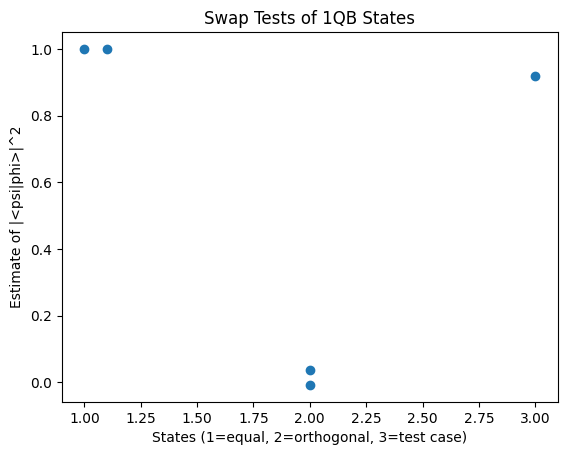

In [13]:
x = (1, 1.1, 2, 2, 3)
plt.scatter(x, similarity_scores)
plt.xlabel('States (1=equal, 2=orthogonal, 3=test case)') 
plt.ylabel('Estimate of |<psi|phi>|^2') 
plt.title('Swap Tests of 1QB States') 

In [14]:
# -----------------------------------------------------------------
# Swap Test on 2 QB States - 1000 shots
# -----------------------------------------------------------------
# Equal states result in a similarity score of 1
# Orthogonal states give a similarity score near 0
# The test case gives a similarity score of 0.526

states_to_compare = [
    
    ([0, 0, 0, 1], [0, 0, 0, 1]),
    ([1, 0, 0, 0], [1, 0, 0, 0]),

    ([1, 0, 0, 0], [0, 0, 0, 1]),
    ([0, 0, 0, 1], [1, 0, 0, 0]),

    ([np.sqrt(.1), np.sqrt(.2), np.sqrt(.6), np.sqrt(.1)], 
     [np.sqrt(0), np.sqrt(.5), np.sqrt(.1), np.sqrt(.4)])
]

similarity_scores = []

for state_1, state_2 in states_to_compare:    

    validate_states(state_1, state_2)

    num_qb_per_state = int(np.log2(len(state_1)))
    print("num qb per state:", num_qb_per_state)
    
    qc = create_circuit(state_1, state_2, num_qb_per_state)
    result = run_circuit(qc)

    similarity_scores.append(compute_similarity_score(result))
    
    print(qc)    

print(similarity_scores)

num qb per state: 2
Job Status: job has successfully run
{'0': 1000}
1.0
                ┌───┐                ┌───┐┌─┐
  q15: ─────────┤ H ├───────────■──■─┤ H ├┤M├
       ┌────────┴───┴─────────┐ │  │ └───┘└╥┘
q16_0: ┤0                     ├─X──┼───────╫─
       │  Initialize(0,0,0,1) │ │  │       ║ 
q16_1: ┤1                     ├─┼──X───────╫─
       ├──────────────────────┤ │  │       ║ 
q17_0: ┤0                     ├─X──┼───────╫─
       │  Initialize(0,0,0,1) │    │       ║ 
q17_1: ┤1                     ├────X───────╫─
       └──────────────────────┘            ║ 
 c5: 1/════════════════════════════════════╩═
                                           0 
num qb per state: 2
Job Status: job has successfully run
{'0': 1000}
1.0
                ┌───┐                ┌───┐┌─┐
  q18: ─────────┤ H ├───────────■──■─┤ H ├┤M├
       ┌────────┴───┴─────────┐ │  │ └───┘└╥┘
q19_0: ┤0                     ├─X──┼───────╫─
       │  Initialize(1,0,0,0) │ │  │       ║ 
q19_1: ┤1                 

Text(0.5, 1.0, 'Swap Tests of 2QB States')

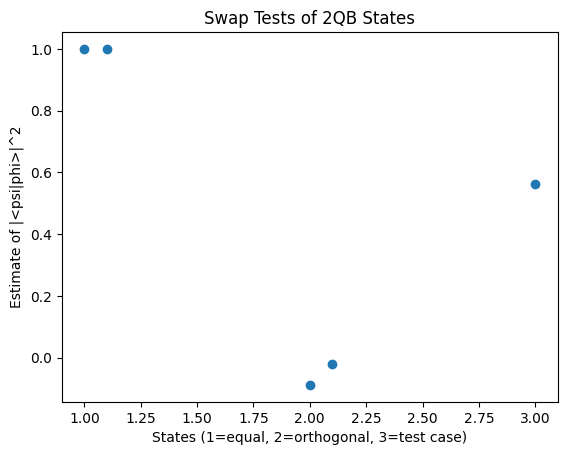

In [15]:
x = (1, 1.1, 2, 2.1, 3)
plt.scatter(x, similarity_scores)
plt.xlabel('States (1=equal, 2=orthogonal, 3=test case)') 
plt.ylabel('Estimate of |<psi|phi>|^2') 
plt.title('Swap Tests of 2QB States')

In [16]:
# -----------------------------------------------------------------
# Swap Test on 3 QB States - 1000 shots
# -----------------------------------------------------------------
# Equal states result in a similarity score of 1
# Orthogonal states give a similarity score near 0
# The test case gives a similarity score of .772

states_to_compare = [
    
    ([0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 0, 1]),
    ([1, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0, 0]),

    ([1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1]),
    ([0, 0, 0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0, 0, 0]),

    ([np.sqrt(.01), np.sqrt(.1), np.sqrt(.12), np.sqrt(.13), np.sqrt(.04), np.sqrt(0), np.sqrt(.35), np.sqrt(.25)], 
     [np.sqrt(0), np.sqrt(.2), np.sqrt(.2), np.sqrt(.1), np.sqrt(.2), np.sqrt(.05), np.sqrt(.05), np.sqrt(.2)])
]

similarity_scores = []

for state_1, state_2 in states_to_compare:    

    validate_states(state_1, state_2)

    num_qb_per_state = int(np.log2(len(state_1)))
    print("num qb per state:", num_qb_per_state)
    
    qc = create_circuit(state_1, state_2, num_qb_per_state)
    result = run_circuit(qc)

    similarity_scores.append(compute_similarity_score(result))
    
    print(qc)    

print(similarity_scores)

num qb per state: 3
Job Status: job has successfully run
{'0': 1000}
1.0
                    ┌───┐                       ┌───┐┌─┐
  q30: ─────────────┤ H ├───────────────■──■──■─┤ H ├┤M├
       ┌────────────┴───┴─────────────┐ │  │  │ └───┘└╥┘
q31_0: ┤0                             ├─X──┼──┼───────╫─
       │                              │ │  │  │       ║ 
q31_1: ┤1 Initialize(0,0,0,0,0,0,0,1) ├─┼──X──┼───────╫─
       │                              │ │  │  │       ║ 
q31_2: ┤2                             ├─┼──┼──X───────╫─
       ├──────────────────────────────┤ │  │  │       ║ 
q32_0: ┤0                             ├─X──┼──┼───────╫─
       │                              │    │  │       ║ 
q32_1: ┤1 Initialize(0,0,0,0,0,0,0,1) ├────X──┼───────╫─
       │                              │       │       ║ 
q32_2: ┤2                             ├───────X───────╫─
       └──────────────────────────────┘               ║ 
c10: 1/═══════════════════════════════════════════════╩═
               

Text(0.5, 1.0, 'Swap Tests of 3QB States')

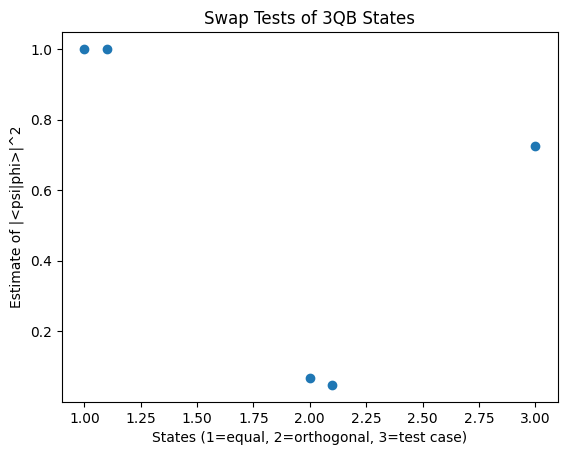

In [17]:
x = (1, 1.1, 2, 2.1, 3)
plt.scatter(x, similarity_scores)
plt.xlabel('States (1=equal, 2=orthogonal, 3=test case)') 
plt.ylabel('Estimate of |<psi|phi>|^2') 
plt.title('Swap Tests of 3QB States')

In [31]:
## Examine running the swap test with a noisy backend
## 1QB State Comparisons

states_to_compare = [
    ([np.sqrt(.3), np.sqrt(.7)], 
     [np.sqrt(.6), np.sqrt(.4)])
]

similarity_scores = []

for state_1, state_2 in states_to_compare:    

    validate_states(state_1, state_2)    

    num_qb_per_state = int(np.log2(len(state_1)))

    qc = create_circuit(state_1, state_2, num_qb_per_state)

    noise_levels = [0, .01, .025, .05, .10, .25, .50]

    for noise_level in noise_levels:
        result = run_circuit(qc, depolarizing_probability=noise_level)

        similarity_scores.append(compute_similarity_score(result))
    
    print(qc)    

print(similarity_scores)

Job Status: job has successfully run
{'1': 40, '0': 960}
0.92
Job Status: job has successfully run
{'0': 936, '1': 64}
0.872
Job Status: job has successfully run
{'0': 925, '1': 75}
0.85
Job Status: job has successfully run
{'0': 892, '1': 108}
0.784
Job Status: job has successfully run
{'1': 165, '0': 835}
0.6699999999999999
Job Status: job has successfully run
{'0': 692, '1': 308}
0.384
Job Status: job has successfully run
{'0': 546, '1': 454}
0.09199999999999997
                    ┌───┐                ┌───┐┌─┐
  q60: ─────────────┤ H ├──────────────■─┤ H ├┤M├
       ┌────────────┴───┴────────────┐ │ └───┘└╥┘
  q61: ┤ Initialize(0.54772,0.83666) ├─X───────╫─
       └┬────────────────────────────┤ │       ║ 
  q62: ─┤ Initialize(0.7746,0.63246) ├─X───────╫─
        └────────────────────────────┘         ║ 
c20: 1/════════════════════════════════════════╩═
                                               0 
[0.92, 0.872, 0.85, 0.784, 0.6699999999999999, 0.384, 0.09199999999999997]


Text(0.5, 1.0, 'Swap Tests of 1QB State')

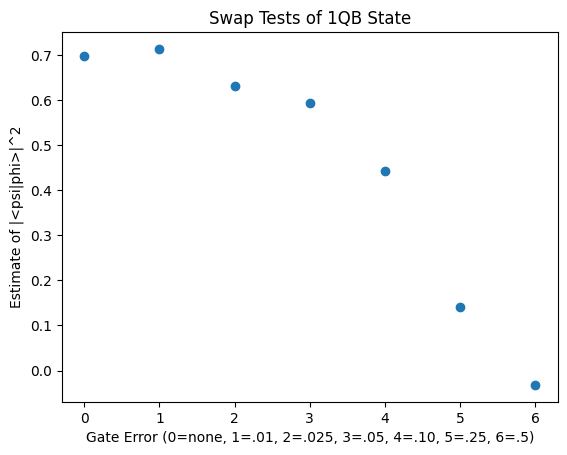

In [39]:
x = (0, 1, 2, 3, 4, 5, 6)
plt.scatter(x, similarity_scores)
plt.xlabel('Gate Error (0=none, 1=.01, 2=.025, 3=.05, 4=.10, 5=.25, 6=.5)') 
plt.ylabel('Estimate of |<psi|phi>|^2') 
plt.title('Swap Tests of 1QB State')

In [33]:
## Examine running the swap test with a noisy backend
## 2QB State Comparisons

states_to_compare = [
    ([np.sqrt(.1), np.sqrt(.2), np.sqrt(.6), np.sqrt(.1)], 
     [np.sqrt(0), np.sqrt(.5), np.sqrt(.1), np.sqrt(.4)])
]

similarity_scores = []

for state_1, state_2 in states_to_compare:    

    validate_states(state_1, state_2)    

    num_qb_per_state = int(np.log2(len(state_1)))

    qc = create_circuit(state_1, state_2, num_qb_per_state)

    noise_levels = [0, .01, .025, .05, .10, .25, .50]

    for noise_level in noise_levels:
        result = run_circuit(qc, depolarizing_probability=noise_level)

        similarity_scores.append(compute_similarity_score(result))
    
    print(qc)    

print(similarity_scores)

Job Status: job has successfully run
{'0': 788, '1': 212}
0.5760000000000001
Job Status: job has successfully run
{'0': 778, '1': 222}
0.556
Job Status: job has successfully run
{'0': 785, '1': 215}
0.5700000000000001
Job Status: job has successfully run
{'0': 745, '1': 255}
0.49
Job Status: job has successfully run
{'0': 710, '1': 290}
0.42000000000000004
Job Status: job has successfully run
{'0': 595, '1': 405}
0.18999999999999995
Job Status: job has successfully run
{'0': 506, '1': 494}
0.01200000000000001
                            ┌───┐                           ┌───┐┌─┐
  q63: ─────────────────────┤ H ├──────────────────────■──■─┤ H ├┤M├
       ┌────────────────────┴───┴────────────────────┐ │  │ └───┘└╥┘
q64_0: ┤0                                            ├─X──┼───────╫─
       │  Initialize(0.31623,0.44721,0.7746,0.31623) │ │  │       ║ 
q64_1: ┤1                                            ├─┼──X───────╫─
       └──┬────────────────────────────────────────┬─┘ │  │       ║ 
q6

Text(0.5, 1.0, 'Swap Tests of 2QB State')

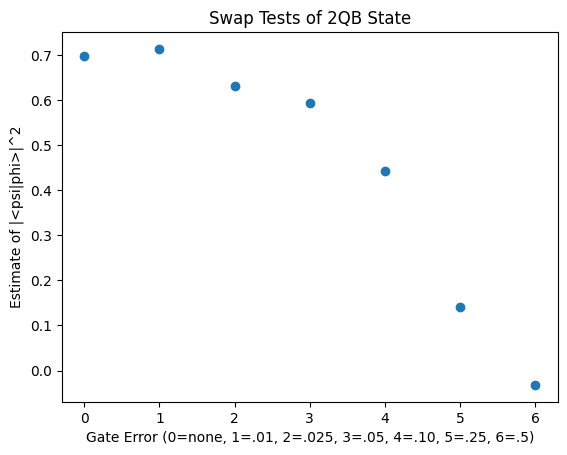

In [38]:
x = (0, 1, 2, 3, 4, 5, 6)
plt.scatter(x, similarity_scores)
plt.xlabel('Gate Error (0=none, 1=.01, 2=.025, 3=.05, 4=.10, 5=.25, 6=.5)') 
plt.ylabel('Estimate of |<psi|phi>|^2') 
plt.title('Swap Tests of 2QB State')

In [35]:
## Examine running the swap test with a noisy backend
## 3QB State Comparisons

states_to_compare = [
    ([np.sqrt(.01), np.sqrt(.1), np.sqrt(.12), np.sqrt(.13), np.sqrt(.04), np.sqrt(0), np.sqrt(.35), np.sqrt(.25)], 
     [np.sqrt(0), np.sqrt(.2), np.sqrt(.2), np.sqrt(.1), np.sqrt(.2), np.sqrt(.05), np.sqrt(.05), np.sqrt(.2)])
]

similarity_scores = []

for state_1, state_2 in states_to_compare:    

    validate_states(state_1, state_2)    

    num_qb_per_state = int(np.log2(len(state_1)))

    qc = create_circuit(state_1, state_2, num_qb_per_state)

    noise_levels = [0, .01, .025, .05, .10, .25, .50]

    for noise_level in noise_levels:
        result = run_circuit(qc, depolarizing_probability=noise_level)

        similarity_scores.append(compute_similarity_score(result))
    
    print(qc)    

print(similarity_scores)

Job Status: job has successfully run
{'0': 849, '1': 151}
0.698
Job Status: job has successfully run
{'0': 857, '1': 143}
0.714
Job Status: job has successfully run
{'0': 816, '1': 184}
0.632
Job Status: job has successfully run
{'0': 797, '1': 203}
0.594
Job Status: job has successfully run
{'0': 722, '1': 278}
0.44399999999999995
Job Status: job has successfully run
{'0': 570, '1': 430}
0.14
Job Status: job has successfully run
{'1': 516, '0': 484}
-0.03200000000000003
       »
  q66: »
       »
q67_0: »
       »
q67_1: »
       »
q67_2: »
       »
q68_0: »
       »
q68_1: »
       »
q68_2: »
       »
c22: 1/»
       »
«                                         ┌───┐                                   »
«  q66: ──────────────────────────────────┤ H ├───────────────────────────────────»
«             ┌───────────────────────────┴───┴────────────────────────────┐      »
«q67_0: ──────┤0                                                           ├──────»
«             │                    

Text(0.5, 1.0, 'Swap Tests of 3QB State')

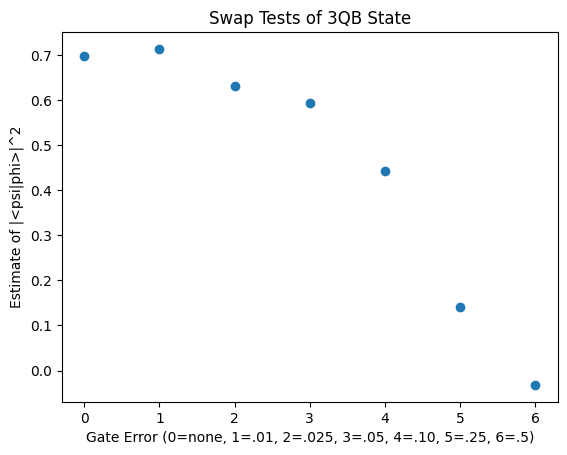

In [37]:
x = (0, 1, 2, 3, 4, 5, 6)
plt.scatter(x, similarity_scores)
plt.xlabel('Gate Error (0=none, 1=.01, 2=.025, 3=.05, 4=.10, 5=.25, 6=.5)') 
plt.ylabel('Estimate of |<psi|phi>|^2') 
plt.title('Swap Tests of 3QB State')